# Chapter 4 - Basics of Deep Learning

In [39]:
import warnings
warnings.simplefilter("ignore")

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import tqdm

from random import choice
from numpy import array, dot, random
import sklearn.datasets
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm_notebook as tqdm
import copy
import itertools
import pandas as pd

np.random.seed(1)
%matplotlib inline

## MLP on Various Datasets
The example explores a two-layer neural network implemented in python and numpy. Uncomment the dataset to be explored:

- Moons Dataset
- Circles Dataset
- XOR
- AND

Modified example from: https://github.com/dennybritz/nn-from-scratch

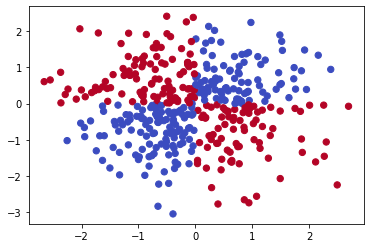

In [2]:
## Generate a dataset and plot it
"""
## Moons Dataset ##
X, y = sklearn.datasets.make_moons(200, noise=0.20)
"""

"""
## Circles dataset ##
X, y = sklearn.datasets.make_circles(noise=0.2, factor=0.5, random_state=1)
"""


## XOR with noise ##
xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(400, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)

"""
## AND with noise ##
xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(400, 2)
y = np.logical_and(X[:, 0] > 0, X[:, 1] > 0).astype(int)
"""

# Plot the dataset
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.coolwarm)

In [3]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

In [4]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function, don't worry. It just generates
# the contour plot below
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [5]:
def calculate_probs(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probs

In [6]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, W2 = model["W1"], model["W2"]
    probs = calculate_probs(model, X)
    # Calculating the loss
    correct_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(correct_logprobs)
    # Add regularization term to loss (optional)
    data_loss += reg_lambda / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [7]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    probs = calculate_probs(model, x)
    return np.argmax(probs, axis=1)

In [10]:
# This function learns prameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_iters: Number of iterations through the training data for gradient descent
# - print_loss: If true, print the loss every 1000 iterations
def build_model(nn_hdim, num_iters=20000, print_loss=False):
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    
    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_iters):
        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        # Add regularizatin terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        
        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset.
        # So We don't want to do ti too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" % (i, calculate_loss(model)))
            
    return model

Loss after iteration 0: 0.757321
Loss after iteration 1000: 0.430950
Loss after iteration 2000: 0.430943
Loss after iteration 3000: 0.430942
Loss after iteration 4000: 0.430941
Loss after iteration 5000: 0.430941
Loss after iteration 6000: 0.430940
Loss after iteration 7000: 0.430940
Loss after iteration 8000: 0.430940
Loss after iteration 9000: 0.430940
Loss after iteration 10000: 0.430939
Loss after iteration 11000: 0.430939
Loss after iteration 12000: 0.430939
Loss after iteration 13000: 0.430939
Loss after iteration 14000: 0.430939
Loss after iteration 15000: 0.430939
Loss after iteration 16000: 0.430939
Loss after iteration 17000: 0.430939
Loss after iteration 18000: 0.430939
Loss after iteration 19000: 0.430939


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

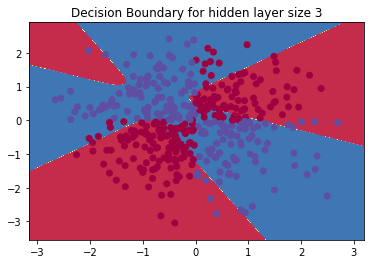

In [20]:
# Build a model with a 3-dimensional hidden layer
hidden_units = 3
model = build_model(hidden_units, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size %i" % hidden_units)

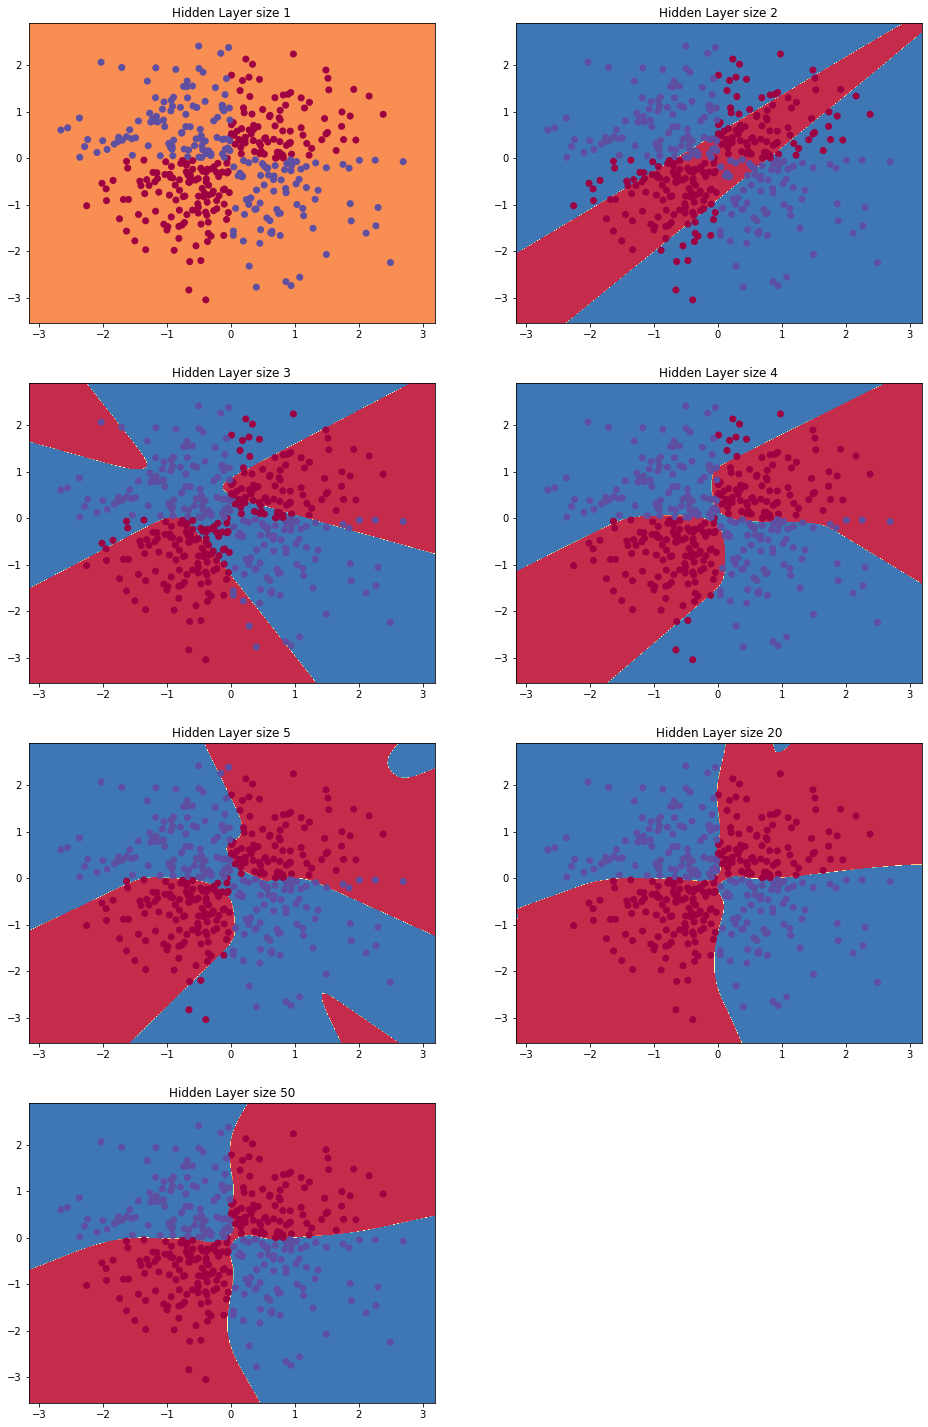

In [21]:
# Experiment with the hidden layer size
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title("Hidden Layer size %d" % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))

# Spoken Digit Dataset
spoken digits classification and generation. Original dataset can be found here: https://github.com/Jakobovski/free-spoken-digit-dataset

In [49]:
import os
from tqdm import tqdm
import soundfile as sf

from scipy.io import wavfile
import IPython.display as ipd
import librosa
import librosa.display

### Download FSDD from Github

In [22]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4182, done.
remote: Counting objects: 100% (510/510), done.
remote: Compressing objects: 100% (510/510), done.
remote: Total 4182 (delta 2), reused 502 (delta 0), pack-reused 3672
Receiving objects: 100% (4182/4182), 30.44 MiB | 7.56 MiB/s, done.
Resolving deltas: 100% (79/79), done.


### Inspect the downloaded data

In [27]:
def plotRawWave(plotTitle, sampleRate, samples, figWidth=14, figHeight=4):
    plt.figure(figsize=(figWidth, figHeight))
    plt.plot(samples)
    plt.title("Raw sound wave of " + plotTitle)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [sec]")
    plt.show()  # force display while in for loop
    return None

def computeLogSpectrogram(audio, sampleRate, windowSize=20, stepSize=10, epsilon=1e-10):
    nperseg  = int(round(windowSize * sampleRate / 1000))
    noverlap = int(round(stepSize   * sampleRate / 1000))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sampleRate,
                                            window='ham',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + epsilon)

def plotSpectrogram(plotTitle, freqs, times, spectrogram, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
               cmap="jet",   #  default was "viridis"  (perceptually uniform)
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.colorbar(pad=0.01)
    plt.title('Spectrogram of ' + plotTitle)
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [sec]")
    fig.tight_layout()
    plt.show()  # force display while in for loop
    return None

def computeMelSpectrogram(samples, sampleRate, nMels=128):
    melSpectrum = librosa.feature.melspectrogram(samples.astype(np.float16), sr=sampleRate, n_mels=nMels)
    
    return melSpectrum

def computeLogMelSpectrogram(samples, sampleRate, nMels=128):
    melSpectrum = librosa.feature.melspectrogram(samples.astype(np.float16), sr=sampleRate, n_mels=128)
    
    # Convert to dB, which is a log scale.  Use peak power as reference.
    logMelSpectrogram = librosa.power_to_db(melSpectrum, ref=np.max)
    
    return logMelSpectrogram

def plotMelSpectrogram(plotTitle, sampleRate, melSpectrum, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    librosa.display.specshow(melSpectrum, sr=sampleRate, x_axis='time', y_axis='mel', cmap="jet")
    plt.title('Mel frequency spectrogram: ' + plotTitle)
    plt.colorbar(pad=0.01, format='%+02.0f dB')
    plt.tight_layout()  
    plt.show()  # force display while in for loop
    return None

def plotLogMelSpectrogram(plotTitle, sampleRate, logMelSpectrum, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    librosa.display.specshow(logMelSpectrum, sr=sampleRate, x_axis='time', y_axis='mel', cmap="jet")
    plt.title('Mel log-frequency power spectrogram: ' + plotTitle)
    plt.colorbar(pad=0.01, format='%+02.0f dB')
    plt.tight_layout()  
    plt.show()  # force display while in for loop
    return None

def computeMFCC(samples, sampleRate, nFFT=512, hopLength=256, nMFCC=40, norm=None):
    mfcc = librosa.feature.mfcc(y=samples.astype(np.float16), sr=sampleRate, 
                                n_fft=nFFT, hop_length=hopLength, n_mfcc=nMFCC,
                                norm=norm)
    
    # Let's add on the first and second deltas 
    mfcc = librosa.feature.delta(mfcc, order=2)
    return mfcc

def plotMFCC(plotTitle, sampleRate, mfcc, figWidth=14, figHeight=4):
    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    fig = plt.figure(figsize=(figWidth, figHeight))
    librosa.display.specshow(mfcc, sr=sampleRate, x_axis='time',cmap="jet")
    plt.colorbar(pad=0.01)
    plt.title("Mel-frequency cepstral coefficients (MFCC): " + plotTitle)
    plt.tight_layout()
    plt.show()  # force display while in for loop
    return None

def showWavefile(filename):
    sampleRate, samples = wavfile.read(filename)  
    plotRawWave(filename, sampleRate, samples)
    
    melSpectrogram = computeMelSpectrogram(samples, sampleRate)
    
    logMelSpectrogram = computeLogMelSpectrogram(samples, sampleRate)
    plotLogMelSpectrogram(filename, sampleRate, logMelSpectrogram)
    
    return sampleRate, samples, logMelSpectrogram

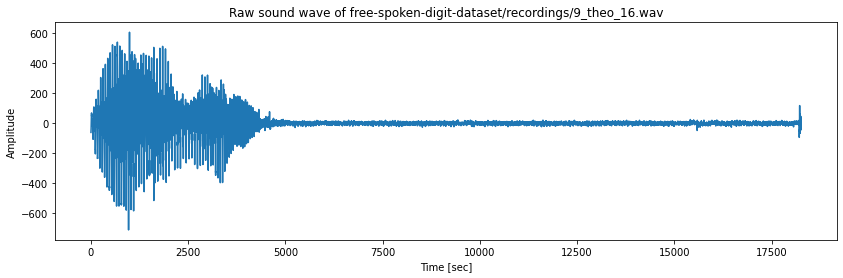

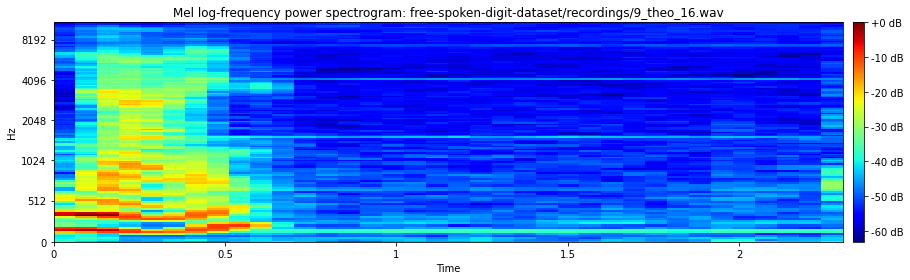

In [40]:
# Sample a file from the dataset
filename = 'free-spoken-digit-dataset/recordings/9_theo_16.wav'

ipd.display(ipd.Audio(filename))
sampleRate, samples, logMelSpectrogram = showWavefile(filename)

In [44]:
y, fs = librosa.load(filename)
y.shape, type(y), fs, len(y) / fs

((50335,), numpy.ndarray, 22050, 2.282766439909297)

## Increase the amount of data: Data Augmentation
The original dataset contains 1,500 examples (it has since grown to 3,000 at the time of this writing). We can create additional examples by augmenting the original files.
Here we apply time stretching and pitch shifting to increase the number of examples.

This has already been computed for convenience, so it is left commented out here.

In [45]:
# Load Wav File Paths
original_wavfiles = []

root = "free-spoken-digit-dataset/recordings/"
for path, dirs, files in os.walk(root, topdown=True):
    for file in files:
        if file.endswith(".wav"):
            original_wavfiles.append(os.path.join(path, file))
print("Number of wavfiles: ", len(original_wavfiles))

Number of wavfiles:  3000


In [50]:
augmented_dir = "./data/wav"
os.makedirs(augmented_dir, exist_ok=True)
# sampling rate = sampling frequency
default_sample_rate = 8000 # Reducing everything to 8kHz phone quality for efficiency

# Create Augmented examples
for file_path in tqdm(original_wavfiles):
    y, Fs = librosa.load(file_path)
    for ts in [0.75, 1, 1.25]:
        for ps in [-1, 0, +1]:
            y_new = librosa.effects.time_stretch(y, ts)
            y_new = librosa.effects.pitch_shift(y_new, Fs, n_steps=ps)
            basename = "_".join([os.path.splitext(os.path.basename(file_path))[0], str(ts), str(ps)])+".wav"
            output_file = os.path.join(augmented_dir, basename)
            #librosa.output.write_wav(output_file, y_new, default_sample_rate)
            # https://pysoundfile.readthedocs.io/en/0.8.1/#soundfile.write
            sf.write(output_file, y_new, default_sample_rate)

100%|██████████| 3000/3000 [05:34<00:00,  8.96it/s]


In [48]:
augmented_wavfiles = []

root = "./data/wav/"
for path, dirs, files in os.walk(root, topdown=True):
    for file in files:
        if file.endswith(".wav"):
            augmented_wavfiles.append(os.path.join(path, file))
print("Number of wavefiles: ", len(augmented_wavfiles))

Note: Loading audio and performing the FFT to convert it to the frequence sectrum requires repetative computation. We can save time on this conversion by computing it once and saving the features in numpy arrays, which will be much faster during loading. Furthermore, even doing this process once can take a significant amoount of time, so we parallelize the process here.

To simplify the network architecture, we fix the size of all examples in the dataset to 1.5s and save them if we need to inspect them.